In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
df=pd.read_csv('/gdrive/MyDrive/ml/urldata.csv')
df=df.drop(['Unnamed: 0','label'], axis = 1)
df.shape

(450176, 2)

In [ ]:
def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens=[]
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokentsByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
    allTokens = list(set(allTokens))
    if 'com' in allTokens:
        allTokens.remove('com')
    return allTokens

In [ ]:
encoder=HashingVectorizer(n_features=300,ngram_range=(1,4),tokenizer=getTokens)
test=encoder.fit_transform(df.url.to_numpy())
test

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


<450176x300 sparse matrix of type '<class 'numpy.float64'>'
	with 8821609 stored elements in Compressed Sparse Row format>

In [ ]:
numpyArray=test.toarray()
panda_df = pd.DataFrame(data = numpyArray[0:, 0:],
                        index = [ str(i + 1) 
                        for i in range(numpyArray.shape[0])],
                        columns = ['Column_' + str(i + 1) 
                        for i in range(numpyArray.shape[1])])


In [ ]:
panda_df.head()

In [ ]:
df['url_length'] = df['url'].apply(lambda i: len(str(i)))
df.head()

,url,result,url_length
0,https://www.google.com,0,22
1,https://www.youtube.com,0,23
2,https://www.facebook.com,0,24
3,https://www.baidu.com,0,21
4,https://www.wikipedia.org,0,25


In [ ]:
from collections import Counter
import itertools

In [ ]:
df['url_schar'] = df['url'].apply(lambda i: len(re.findall(':|_|\?|=|&',i)))
df.head()

,url,result,url_length,url_schar
0,https://www.google.com,0,22,1
1,https://www.youtube.com,0,23,1
2,https://www.facebook.com,0,24,1
3,https://www.baidu.com,0,21,1
4,https://www.wikipedia.org,0,25,1


In [ ]:
def digit_ratio(url):
    digits = 0
    l=0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
        if i.isalpha():
            l=l+1
    return digits/l
df['url_dtl'] = df['url'].apply(lambda i: digit_ratio(i))

In [ ]:
!pip install tld

In [ ]:
df.head()
from urllib.parse import urlparse
from tld import get_tld
import os.path
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
def tld_length(tld):
    try:
        if tld in ['ru','cn','surf','tw','to','gq','ml'] :
          return 1
        else:
          return 0
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))
df['hostname_length'] = df['url'].apply(lambda i: len(urlparse(i).netloc))
df.head()

,url,result,url_length,url_schar,url_dtl,tld,tld_length,use_of_ip,hostname_length
0,https://www.google.com,0,22,1,0.0,com,0,0,14
1,https://www.youtube.com,0,23,1,0.0,com,0,0,15
2,https://www.facebook.com,0,24,1,0.0,com,0,0,16
3,https://www.baidu.com,0,21,1,0.0,com,0,0,13
4,https://www.wikipedia.org,0,25,1,0.0,org,0,0,17


In [ ]:
!pip install tldextract

In [ ]:
import tldextract
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count-digits']= df['url'].apply(lambda i: digit_count(urlparse(i).netloc))
df['hyphen']= df['url'].apply(lambda i: urlparse(i).netloc.count('-'))
df['and']= df['url'].apply(lambda i: urlparse(i).netloc.count('@'))  
df['subdomain']= df['url'].apply(lambda i: tldextract.extract(i).subdomain.count('.'))
df.head()  

,url,result,url_length,url_schar,url_dtl,tld,tld_length,use_of_ip,hostname_length,count-digits,hyphen,and,subdomain
0,https://www.google.com,0,22,1,0.0,com,0,0,14,0,0,0,0
1,https://www.youtube.com,0,23,1,0.0,com,0,0,15,0,0,0,0
2,https://www.facebook.com,0,24,1,0.0,com,0,0,16,0,0,0,0
3,https://www.baidu.com,0,21,1,0.0,com,0,0,13,0,0,0,0
4,https://www.wikipedia.org,0,25,1,0.0,org,0,0,17,0,0,0,0


In [ ]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))

In [ ]:
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('%20')
df['count_20'] = df['url'].apply(lambda i: no_of_embed(i))
df.head()  

,url,result,url_length,url_schar,url_dtl,tld,tld_length,use_of_ip,hostname_length,count-digits,hyphen,and,subdomain,count_dir,count_embed_domian,count_20
0,https://www.google.com,0,22,1,0.0,com,0,0,14,0,0,0,0,0,0,0
1,https://www.youtube.com,0,23,1,0.0,com,0,0,15,0,0,0,0,0,0,0
2,https://www.facebook.com,0,24,1,0.0,com,0,0,16,0,0,0,0,0,0,0
3,https://www.baidu.com,0,21,1,0.0,com,0,0,13,0,0,0,0,0,0,0
4,https://www.wikipedia.org,0,25,1,0.0,org,0,0,17,0,0,0,0,0,0,0


In [ ]:
def spchar(url):
    urldir = urlparse(url).path
    return len(re.findall("[$&+,:;=?@#|'<>.-^*()%!]",urldir))
df['count_spchar'] = df['url'].apply(lambda i: spchar(i))

In [ ]:

df['count_query'] = df['url'].apply(lambda i: len(urlparse(i).query))
df.head()  

,url,result,url_length,url_schar,url_dtl,tld,tld_length,use_of_ip,hostname_length,count-digits,hyphen,and,subdomain,count_dir,count_embed_domian,count_20,count_spchar,count_query
0,https://www.google.com,0,22,1,0.0,com,0,0,14,0,0,0,0,0,0,0,0,0
1,https://www.youtube.com,0,23,1,0.0,com,0,0,15,0,0,0,0,0,0,0,0,0
2,https://www.facebook.com,0,24,1,0.0,com,0,0,16,0,0,0,0,0,0,0,0,0
3,https://www.baidu.com,0,21,1,0.0,com,0,0,13,0,0,0,0,0,0,0,0,0
4,https://www.wikipedia.org,0,25,1,0.0,org,0,0,17,0,0,0,0,0,0,0,0,0


In [ ]:
new_df=df.drop(['url','tld'], axis = 1)
new_df.head()

,result,url_length,url_schar,url_dtl,tld_length,use_of_ip,hostname_length,count-digits,hyphen,and,subdomain,count_dir,count_embed_domian,count_20,count_spchar,count_query
0,0,22,1,0.0,0,0,14,0,0,0,0,0,0,0,0,0
1,0,23,1,0.0,0,0,15,0,0,0,0,0,0,0,0,0
2,0,24,1,0.0,0,0,16,0,0,0,0,0,0,0,0,0
3,0,21,1,0.0,0,0,13,0,0,0,0,0,0,0,0,0
4,0,25,1,0.0,0,0,17,0,0,0,0,0,0,0,0,0


In [ ]:
cols = new_df.columns.tolist()
cols = cols[1:] + cols[0:1]
new_df = new_df[cols]
new_df.head()

,url_length,url_schar,url_dtl,tld_length,use_of_ip,hostname_length,count-digits,hyphen,and,subdomain,count_dir,count_embed_domian,count_20,count_spchar,count_query,result
0,22,1,0.0,0,0,14,0,0,0,0,0,0,0,0,0,0
1,23,1,0.0,0,0,15,0,0,0,0,0,0,0,0,0,0
2,24,1,0.0,0,0,16,0,0,0,0,0,0,0,0,0,0
3,21,1,0.0,0,0,13,0,0,0,0,0,0,0,0,0,0
4,25,1,0.0,0,0,17,0,0,0,0,0,0,0,0,0,0


In [ ]:
new_df.reset_index(drop=True, inplace=True)
panda_df.reset_index(drop=True, inplace=True)
test_features=pd.concat([panda_df, new_df] , axis=1)
test_features

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,Column_11,Column_12,Column_13,Column_14,Column_15,Column_16,Column_17,Column_18,Column_19,Column_20,Column_21,Column_22,Column_23,Column_24,Column_25,Column_26,Column_27,Column_28,Column_29,Column_30,Column_31,Column_32,Column_33,Column_34,Column_35,Column_36,Column_37,Column_38,Column_39,Column_40,...,Column_977,Column_978,Column_979,Column_980,Column_981,Column_982,Column_983,Column_984,Column_985,Column_986,Column_987,Column_988,Column_989,Column_990,Column_991,Column_992,Column_993,Column_994,Column_995,Column_996,Column_997,Column_998,Column_999,Column_1000,url_length,url_schar,url_dtl,tld_length,use_of_ip,hostname_length,count-digits,hyphen,and,subdomain,count_dir,count_embed_domian,count_20,count_spchar,count_query,result
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,1,0.000000,0,0,14,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,1,0.000000,0,0,15,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,1,0.000000,0,0,16,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,1,0.000000,0,0,13,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25,1,0.000000,0,0,17,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43,1,0.000000,0,0,11,0,1,0,0,3,0,0,4,0,1
450172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159,4,0.177966,0,0,13,0,0,0,0,12,0,0,42,0,1
450173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.288675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147,3,0.183486,0,0,13,0,0,0,0,12,0,0,40,0,1
450174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,1,0.000000,0,0,14,0,0,0,0,1,0,0,1,0

In [ ]:
from sklearn.model_selection import train_test_split
new_df.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(test_features.drop('result', axis = 1), test_features.result, test_size = 0.25, random_state = 42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_state = 0
rf = RandomForestClassifier(random_state=random_state)

rf.fit(train_features, train_labels)


RandomForestClassifier(random_state=0)

In [ ]:
import pickle
pickle.dump(rf, open('rf300_4.pki', 'wb'))



In [ ]:

y_pred1 = rf.predict(test_features)

# evaluate predictions


In [ ]:
y_pred1=loaded_model.predict(test_features)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, y_pred1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.14%


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred1, target_names=['0','1']))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     86481
           1       0.99      0.93      0.96     26063

    accuracy                           0.98    112544
   macro avg       0.99      0.96      0.97    112544
weighted avg       0.98      0.98      0.98    112544



In [ ]:
from sklearn.metrics import accuracy_score, precision_score,recall_score , roc_auc_score,roc_curve
accuracy = accuracy_score(test_labels, y_pred1)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, y_pred1)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, y_pred1)
print('Recall: %f' % recall)

roc_auc_score(test_labels, y_pred1)

Accuracy: 0.981438
Precision: 0.993495
Recall: 0.925910


0.9620416516935926

AUC of ROC Curve: 0.9939413966527146


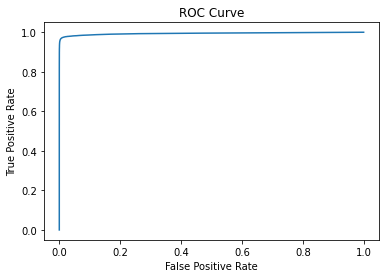

In [ ]:
scores = rf.predict_proba(test_features)[:,1]
fpr, tpr, thresholds = roc_curve(test_labels, scores)

import matplotlib.pyplot as plt
roc_auc = roc_auc_score(test_labels, scores)
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
accuracy = confusion_matrix(test_labels, y_pred1)

In [ ]:
accuracy

array([[86075,   107],
       [ 1584, 24778]])

In [ ]:
!cp rf300_4.pki /gdrive/MyDrive/ml/